In [37]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import s3fs
import tqdm
import subprocess
import shutil, os, glob
import genomeview
import pyBigWig
from plotnine import *

def extract_bw_trace(input_bw, chrom, start, end):
    with pyBigWig.open(input_bw) as bw:
        bw_arr = bw.values(chrom, start, end, numpy=True)
    return bw_arr

def plotdf_bw_series(bw_fn_list, sample_name_list, chrom, start, end):
    results_df = pd.DataFrame()
    for bw_fn,sample_name in zip(bw_fn_list, sample_name_list):
        results_slice = pd.DataFrame({'coverage':extract_bw_trace(bw_fn, chrom, start, end).tolist()})
        results_slice['sample'] = sample_name
        results_slice['pos'] = [x for x in range(start,end)]
        results_df = results_df.append(results_slice)
    return results_df

In [19]:
crosses_df = pd.read_csv('s3://darmanis-group/danle/botryllus/botryllus_samples.csv')
crosses_df = crosses_df[[x is not np.nan for x in crosses_df['Chimeras set']]] # remove all nan rows
targetfn_df = pd.melt(crosses_df, id_vars=['Chimeras set','Time chimera sampled following fusion'])
targetfn_df['translated_value'] = [ x.replace(' ', '_') \
                                     .replace('  ', '_') \
                                     .replace('.', '_') \
                                     .replace('..', '_') \
                                     .replace('-', '_') \
                                     .replace('--', '_') \
                                     .replace('__', '_') \
                                     .replace('ï','i') if x is not np.nan \
                                   else x \
                                   for x in targetfn_df['value']
                                  ]
# create sample id conversion
value2id_dict = {}
for val_val, key_val in enumerate(targetfn_df['translated_value'].drop_duplicates().dropna()):
    value2id_dict[key_val] = f'sample_{val_val}'
value2id_dict[np.nan] = np.nan
targetfn_df['sample_id'] = [value2id_dict.get(x) for x in targetfn_df['translated_value']]
id2value_dict = {y:x for x,y in value2id_dict.items()} # translate back

# project new sample ids on original experiment matrix
for variable_val in set(targetfn_df['variable']):
    crosses_dict = {}
    targetfn_slice = targetfn_df[targetfn_df['variable']==variable_val]
    targetfn_slice = targetfn_slice[[x is not np.nan for x in targetfn_slice['value']]]
    for row_idx in range(len(targetfn_slice)):
        targetfn_slice_slice = targetfn_slice.iloc[row_idx, :]
        keyval = targetfn_slice_slice['value']
        valval = targetfn_slice_slice['sample_id']
        crosses_dict[keyval] = valval
    crosses_dict[np.nan] = np.nan
    crosses_df[variable_val] = [crosses_dict.get(x) for x in crosses_df[variable_val]]


In [20]:
fs_df = pd.read_csv('/home/daniel_le/data/botryllus/fs.txt', header=None)
fs_df.columns = ['path']
fs_df['fastq'] = [x.endswith('q.gz') for x in fs_df['path']]
fs_df = fs_df[fs_df['fastq'] == True]
fs_df['fn'] = [x.split('/')[-1] for x in fs_df['path']]
fs_df['d1_dir'] = [x.split('/')[-2] for x in fs_df['path']]
fs_df['d1_dir_translated'] = [ x.replace(' ', '_') \
                                 .replace('  ', '_') \
                                 .replace('.', '_') \
                                 .replace('..', '_') \
                                 .replace('-', '_') \
                                 .replace('--', '_') \
                                 .replace('__', '_') \
                               for x in fs_df['d1_dir']
                              ]
fs_df['fn_translated'] = [ x.replace(' ', '_') \
                                 .replace('  ', '_') \
                                 .replace('.', '_') \
                                 .replace('..', '_') \
                                 .replace('-', '_') \
                                 .replace('--', '_') \
                                 .replace('__', '_') \
                               for x in fs_df['fn']
                              ]


In [21]:
match_df = pd.DataFrame()
for target in tqdm.tqdm(targetfn_df['translated_value'].drop_duplicates().dropna()):
    if '944axByd196_6_x_sc109e_92' in target:
        word_len = 30
    else:
        word_len = len(target)
    fs_df_slice = fs_df[[x.startswith(target[:word_len]) or y.startswith(target[:word_len]) \
                         for x,y in zip(fs_df['fn_translated'], fs_df['d1_dir_translated'])]]
    fs_df_slice['target'] = target
    match_df = match_df.append(fs_df_slice)
match_df['sample_id'] = [value2id_dict.get(x) for x in match_df['target']]
match_df = match_df.drop_duplicates()

# metrics
targets = set(targetfn_df['translated_value'].dropna())
print('targets:', len(targets))

hits = set(match_df['target'])
print('hits:', len(hits))

missing = targets-hits
[print(x) for x in missing]


  0%|          | 0/98 [00:00<?, ?it/s]/home/daniel_le/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
100%|██████████| 98/98 [00:00<00:00, 364.64it/s]

targets: 98
hits: 97
3966_944axByd196_6_x_sc109e_92_resorbing_zooid_early_D_chimera_944_side_DCRS


[None]

In [22]:
# check if R1/R2 are properly paired
match_df['fn_translated_prefix'] = [(x
                                     .replace('-R1.','_R2_')
                                     .replace('_R1_','_R2_')
                                    ) for x in match_df['fn_translated']]
match_df_check = pd.DataFrame(match_df
                              .groupby('sample_id')['fn_translated_prefix']
                              .value_counts()
                              .rename('count')).reset_index()
match_df_check[match_df_check['count']!=2]


,sample_id,fn_translated_prefix,count


In [82]:
run_me = True
if run_me == True:
    output_dir = '/home/daniel_le/data/botryllus/results/'
    tmp_dir = '/home/daniel_le/data/botryllus/tmp/'
    indexed_fasta = '/home/daniel_le/data/botryllus/genome/botznik-chr.fa'
    n_threads = 32

    # update queue based on completed targets
    queued_targets = list(set(match_df['sample_id']))
    completed_targets = [x.split('/')[-1].split('.sorted.bam.bai')[0] for x in glob.glob(f'{output_dir}*') if x.endswith('.bai')]
    queued_targets = list(set(queued_targets)-set(completed_targets))

    # iterate through queue
#     for sample in tqdm.tqdm(queued_targets):
    for sample in tqdm.tqdm(['sample_73']): # for single testing
        print('starting', sample)
        # prep tmp folder
        if os.path.exists(tmp_dir):
            shutil.rmtree(tmp_dir)
            os.mkdir(tmp_dir)
        else:
            os.mkdir(tmp_dir)
        # prep output foler    
        if os.path.exists(output_dir):
            pass
        else:
            os.mkdir(output_dir)

    #     # set file names
        tmp_R1_fn = f'{tmp_dir}R1.fq.gz'
        tmp_R2_fn = f'{tmp_dir}R2.fq.gz'
        tmp_sam = f'{tmp_dir}{sample}.sam'
        tmp_bam = f'{tmp_dir}{sample}.bam'
        output_sortedbam = f'{output_dir}{sample}.sorted.bam'

        # rclone subprocess call to download files
        match_df_slice = match_df[match_df['sample_id'] == sample]
        input_fastqs = match_df_slice['path'].tolist()
        for input_path in input_fastqs:
            subprocess.call(['rclone',
                             'copy',
                             f'gdrive:Botryllus/{input_path}',
                             tmp_dir,
                            ])

        # extract files in tmp for cat
        R1_inputs = sorted([x for x in glob.glob(f'{tmp_dir}*') if ('-R1.' in x) or ('_R1_' in x)])
        R2_inputs = sorted([x for x in glob.glob(f'{tmp_dir}*') if ('-R2.' in x) or ('_R2_' in x)])
        for inputs,outfn in zip([R1_inputs,R2_inputs], [tmp_R1_fn,tmp_R2_fn]):
            for input_fn in inputs:
                with open(outfn, 'a') as outfile:
                    subprocess.call(['cat', input_fn], stdout=outfile)

        # run bwa mem
        with open(tmp_sam, 'w') as outfile:
            subprocess.call(['bwa',
                             'mem',
                             '-t',
                             str(n_threads),
                             '-M',
                             indexed_fasta,
                             tmp_R1_fn,
                             tmp_R2_fn,
                            ], stdout=outfile)

        # samtools convert sam to bam
        with open(tmp_bam, 'w') as outfile:
            subprocess.call(['samtools',
                             'view',
                             '-S',
                             '-b',
                             tmp_sam,
                            ], stdout=outfile)

        # samtools sort bam
        with open(output_sortedbam, 'w') as outfile:
            subprocess.call(['samtools',
                             'sort',
                             tmp_bam,
                            ], stdout=outfile)

        # samtools index sorted bam
        subprocess.call(['samtools',
                         'index',
                         output_sortedbam,
                        ])

        print('completed')


  0%|          | 0/1 [00:00<?, ?it/s]

starting sample_73


100%|██████████| 1/1 [28:06<00:00, 1686.35s/it]

completed


---
Chimeras set: Set 7 chimera during resorption 944axByd196.6 x sc109e.92
Sampling time: 1 month following fusion during resorption
---
Partner 1 soma naaive : 3890_Sc109e_old_zooid_D_mid_Late_kp
Partner 2 soma naaiv : Sample_2818_944axByd196_6_4_145_naive_IL4607_5
Chimera soma : 3967_944axByd196_6_x_sc109e_92_primary_bud_early_D_chimera_944_side_DCRS


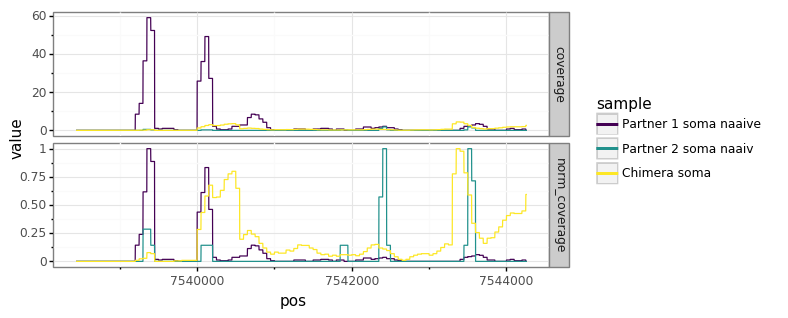

<ggplot: (8783369214973)>


In [83]:
# extract samples from a Chimera set for pile up display
row_idx = 27

cross_slice = crosses_df.iloc[row_idx,:].T.tolist()
cross_slice_dict = crosses_df.iloc[row_idx,:].to_dict()
print('---')
print('Chimeras set:', cross_slice_dict.get('Chimeras set'))
print('Sampling time:', cross_slice_dict.get('Time chimera sampled following fusion'))
print('---')
cross_slice_dict = {y:x for x,y in cross_slice_dict.items()}
sample_list = [x.split('_')[-1] for x in cross_slice if str(x).startswith('sample_')]

fasta_path = '/home/daniel_le/data/botryllus/genome/botznik-chr.fa'
genebed_path = '/home/daniel_le/data/botryllus/genome/botznik-chr-all.bed'
n_threads = 16

# check and process as needed
for sample_index in sample_list:
    try:
        dataset_paths = [genebed_path]
        bw_path = f'/home/daniel_le/data/botryllus/coverage/sample_{sample_index}.bw'
        bam_path = f'/home/daniel_le/data/botryllus/results/sample_{sample_index}.sorted.bam'
        print(cross_slice_dict.get(f'sample_{sample_index}'), 
              ':',
              id2value_dict.get(f'sample_{sample_index}')
             )
        if not os.path.exists(bw_path):
            subprocess.call([
                            'bamCoverage',
                            '-p',
                            str(n_threads),
                            '--normalizeUsing',
                            'CPM',
                            '--ignoreDuplicates',
                            '-b',
                            bam_path,
                            '-o',
                            bw_path,
                            ])
        dataset_paths = dataset_paths+[bw_path]
    except:
        pass

# plot set
# BHF = chr9:7538434..7544266
bw_fn_list = [f'/home/daniel_le/data/botryllus/coverage/sample_{sample_index}.bw' for sample_index in sample_list]
sample_name_list = [cross_slice_dict.get(f'sample_{sample_index}') for sample_index in sample_list]
chrom = 'chr9'
start = 7538434
end =   7544266

plotdf = plotdf_bw_series(bw_fn_list, sample_name_list, chrom, start, end)
plotdf['sample'] = (plotdf['sample']
                    .astype(str)
                    .astype(CategoricalDtype(sample_name_list, ordered=True))
                   )
plotdf['norm_coverage'] = (plotdf.groupby(['sample','pos'])['coverage'].sum()/ \
                           plotdf.groupby('sample')['coverage'].max()
                          ).values
plotdf = pd.melt(plotdf, id_vars=['sample','pos'])
                        
plot = (ggplot(plotdf)
        + theme_bw()
        + theme(aspect_ratio = 1/4)
        + geom_line(aes('pos','value',color='sample',group='sample'))
        + facet_grid('variable~.', scales='free')
       )
print(plot)

    

In [40]:
crosses_df

,Chimeras set,Partner 1 soma naaive,Partner 1 test naïve,Partner 2 soma naaiv,Partner 2 test naïve,Chimera soma,Cimera test,Time chimera sampled following fusion
0,Control 1 touch- 5139jL11HMBYSc6ab15 vs 944axB...,sample_0,NaN,sample_31,NaN,sample_47,NaN,touching no blood vessel fused
1,Control 1 touch- 5139jL11HMBYSc6ab15 vs 944axB...,sample_1,NaN,sample_32,NaN,sample_48,NaN,touching no blood vessel fused
2,Control 1 touch- 5139jL11HMBYSc6ab15 vs 944axB...,sample_2,NaN,sample_33,NaN,sample_49,NaN,touching no blood vessel fused
3,Control 1 touch- 5139jL11HMBYSc6ab15 vs 944axB...,sample_3,NaN,sample_34,NaN,sample_50,NaN,touching no blood vessel fused
4,Control 1 touch- 5139jL11HMBYSc6ab15 vs 944axB...,sample_4,NaN,sample_35,NaN,sample_51,NaN,touching no blood vessel fused
5,Control 1 touch- 5139jL11HMBYSc6ab15 vs 944axB...,NaN,NaN,sample_36,NaN,sample_52,NaN,touching no blood vessel fused
6,Set 1 chimera- 5139jL11HMBYSc6ab15 vs 944axBYd...,sample_3,NaN,sample_33,NaN,sample_53,sample_87,2 months
7,Set 1 chimera- 5139jL11HMBYSc6ab15 vs 944axBYd...,sample_4,NaN,sample_34,NaN,sample_54,sample_88,2 months
8,Set 2_ chimera 944axBYd196.6.4 vs. HM9axBYd196...,sample_5,NaN,sample_37,NaN,sample_55,sample_89,5 months
9,Set 2_ chimera 944axBYd196.6.4 vs. HM9axBYd196...,NaN,NaN,sample_38,NaN,sample_56,NaN,5 months
